In [1]:
# Load packages
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import itertools
import warnings

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa import stattools
from statsmodels.graphics import tsaplots
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.arima.model import ARIMA

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional

from timeit import default_timer as timer    


warnings.filterwarnings('ignore')

In [9]:
data = pd.read_excel("F:/Dataset/CleanedDatasetEnergy.xlsx" , sheet_name = 0)

In [10]:
data.columns

Index(['Time', 'DdF', 'Dd', 'NetGen', 'TotalInter'], dtype='object')

In [11]:
data = data.set_index('Time')

In [12]:
col = ["NetGen","TotalInter","DdF"]
data = data.drop(col , axis=1)

In [13]:
data

,Dd
Time,
2021-04-01 01:00:00,25969
2021-04-01 02:00:00,25033
2021-04-01 03:00:00,24358
2021-04-01 04:00:00,23998
2021-04-01 05:00:00,24355
...,...
2021-06-14 20:00:00,43820
2021-06-14 21:00:00,42568
2021-06-14 22:00:00,40833


In [17]:
data.notnull().count()

Dd    1800
dtype: int64

In [18]:
ts_train = data[:1500]
ts_test= data[1500:]

In [19]:
ts_test

,Dd
Time,
2021-06-02 13:00:00,33924
2021-06-02 14:00:00,35618
2021-06-02 15:00:00,37399
2021-06-02 16:00:00,38955
2021-06-02 17:00:00,40402
...,...
2021-06-14 20:00:00,43820
2021-06-14 21:00:00,42568
2021-06-14 22:00:00,40833


In [20]:
rnn_ts_train = np.array(ts_train)
rnn_ts_train = rnn_ts_train.reshape(ts_train.shape[0],1)

In [21]:
rnn_ts_train

array([[25969],
       [25033],
       [24358],
       ...,
       [31766],
       [32053],
       [32861]], dtype=int64)

In [22]:
Scaler = MinMaxScaler()
rnn_ts_train_scaled = Scaler.fit_transform(ts_train)

In [23]:
# Create our data RNN np arrays

RNN_X_train = []
RNN_y_train = []

n_past = 60
n_future = 1


for i in range(0,len(rnn_ts_train_scaled)-n_past-n_future+1):
    RNN_X_train.append(rnn_ts_train_scaled[i : i + n_past , 0])
    RNN_y_train.append(rnn_ts_train_scaled[i + n_past : i + n_past + n_future , 0 ])

RNN_X_train, RNN_y_train = np.array(RNN_X_train), np.array(RNN_y_train)

In [24]:
RNN_X_train

array([[0.25334011, 0.21006888, 0.17886367, ..., 0.19606121, 0.14876797,
        0.10295409],
       [0.21006888, 0.17886367, 0.16222089, ..., 0.14876797, 0.10295409,
        0.07544727],
       [0.17886367, 0.16222089, 0.17872498, ..., 0.10295409, 0.07544727,
        0.07466137],
       ...,
       [0.59313023, 0.49993066, 0.39822477, ..., 0.39420276, 0.45000231,
        0.51028616],
       [0.49993066, 0.39822477, 0.32647589, ..., 0.45000231, 0.51028616,
        0.52133512],
       [0.39822477, 0.32647589, 0.26004346, ..., 0.51028616, 0.52133512,
        0.53460312]])

In [25]:
#R eshape to the Keras 3D tensor input shape
RNN_X_train = np.reshape(RNN_X_train,(RNN_X_train.shape[0],RNN_X_train.shape[1],1))

In [26]:
RNN_X_train.shape

(1440, 60, 1)

In [27]:
# Initialise the RNN
regressor = Sequential()

# Add the first LSTM layer
regressor.add(Bidirectional(LSTM(units=50,return_sequences=True,input_shape=(RNN_X_train.shape[1],1))))
regressor.add(Dropout(0.2)) # 20% of the neurons will be ignored, for regularisation

# Add more LSTM layers
regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2)) 

# Add the last LSTM layer
regressor.add(LSTM(units=50,return_sequences=False))
regressor.add(Dropout(0.2)) 

#Add the output layer
regressor.add(Dense(units= 50, activation='swish'))

In [28]:
# Compile & Train
start = timer()

regressor.compile(optimizer = 'adam', loss='mean_squared_error')
RNN_hist = regressor.fit(RNN_X_train, RNN_y_train, epochs = 50, batch_size = 32)

runtime = timer()-start

Epoch 1/50
45/45 [==============================] - 21s 130ms/step - loss: 0.1075
Epoch 2/50
45/45 [==============================] - 6s 142ms/step - loss: 0.0341
Epoch 3/50
45/45 [==============================] - 7s 146ms/step - loss: 0.0270
Epoch 4/50
45/45 [==============================] - 6s 141ms/step - loss: 0.0173
Epoch 5/50
45/45 [==============================] - 6s 126ms/step - loss: 0.0150
Epoch 6/50
45/45 [==============================] - 6s 123ms/step - loss: 0.0108
Epoch 7/50
45/45 [==============================] - 6s 131ms/step - loss: 0.0096
Epoch 8/50
45/45 [==============================] - 6s 127ms/step - loss: 0.0077
Epoch 9/50
45/45 [==============================] - 6s 123ms/step - loss: 0.0071
Epoch 10/50
45/45 [==============================] - 5s 120ms/step - loss: 0.0060
Epoch 11/50
45/45 [==============================] - 6s 129ms/step - loss: 0.0053
Epoch 12/50
45/45 [==============================] - 6s 139ms/step - loss: 0.0066
Epoch 13/50
45/45 [=====

In [29]:
dataset_total = pd.concat((ts_train,ts_test),axis=0)
inputs = dataset_total[len(dataset_total) - len(ts_test) - n_past - n_future +1:].values

In [30]:
inputs.shape

(360, 1)

In [31]:
inputs = inputs.reshape(-1,1)
inputs = Scaler.transform(inputs)

In [32]:
inputs.shape

(360, 1)

In [33]:
RNN_X_test = []

for i in range(0,len(inputs)-n_past-n_future+1): # we have to start our test data at 60
    RNN_X_test.append(inputs[i : i + n_past , 0])

RNN_X_test = np.array(RNN_X_test)

In [34]:
RNN_X_test.shape

(300, 60)

In [35]:
# Move test set to 3D structure, as expected by the RNN
RNN_X_test = np.reshape(RNN_X_test,(RNN_X_test.shape[0],RNN_X_test.shape[1],1))

In [36]:
RNN_X_test.shape

(300, 60, 1)

In [37]:
# Predict
RNN_pred = regressor.predict(RNN_X_test)

In [38]:
RNN_pred = Scaler.inverse_transform(RNN_pred)

In [39]:
RNN_pred = pd.DataFrame(RNN_pred)[0]
RNN_pred.index = ts_test.index

In [40]:
RNN_pred

Time
2021-06-02 13:00:00    33925.820312
2021-06-02 14:00:00    35217.332031
2021-06-02 15:00:00    36787.496094
2021-06-02 16:00:00    38267.941406
2021-06-02 17:00:00    39318.117188
                           ...     
2021-06-14 20:00:00    41520.210938
2021-06-14 21:00:00    40637.367188
2021-06-14 22:00:00    39102.699219
2021-06-14 23:00:00    36863.488281
2021-06-15 00:00:00    34117.125000
Name: 0, Length: 300, dtype: float32

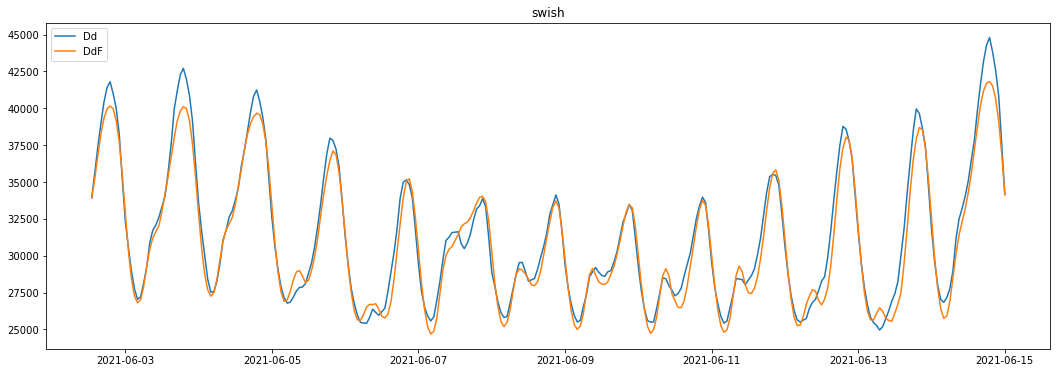

In [42]:
RNN_pred_data = pd.merge(pd.DataFrame(ts_test),RNN_pred,on=['Time'])
RNN_pred_data.columns = ['Dd','DdF']
plt.figure(figsize=(18,6))
# sns.lineplot(data=RNN_pred_data,palette="hot" )
plt.plot(RNN_pred_data)
plt.legend(RNN_pred_data)
plt.title("swish")
plt.show()

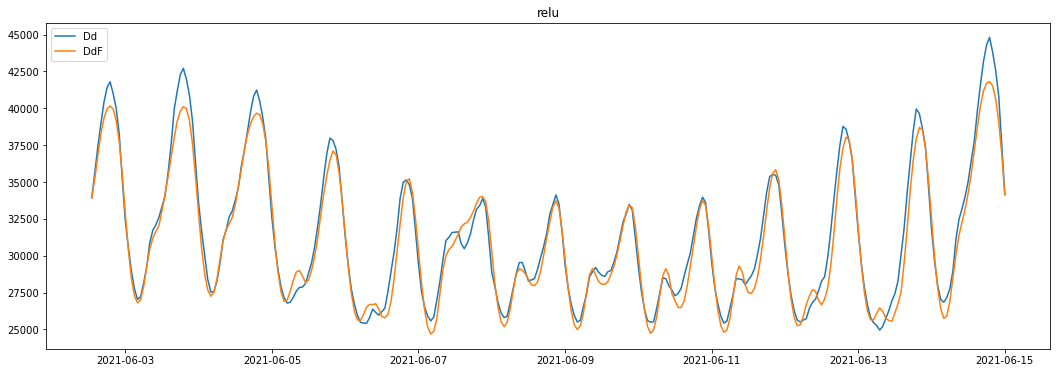

In [43]:
RNN_pred_data = pd.merge(pd.DataFrame(ts_test),RNN_pred,on=['Time'])
RNN_pred_data.columns = ['Dd','DdF']
plt.figure(figsize=(18,6))
# sns.lineplot(data=RNN_pred_data,palette="hot" )
plt.plot(RNN_pred_data)
plt.legend(RNN_pred_data)
plt.title("relu")
plt.show()

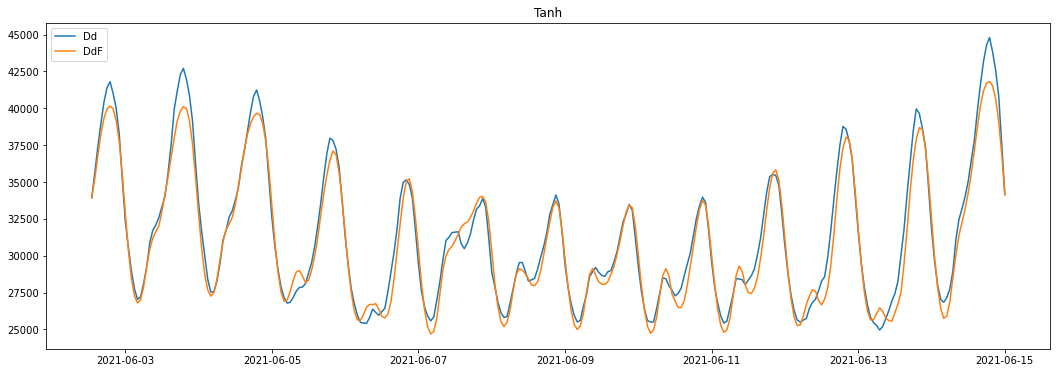

In [44]:
RNN_pred_data = pd.merge(pd.DataFrame(ts_test),RNN_pred,on=['Time'])
RNN_pred_data.columns = ['Dd','DdF']
plt.figure(figsize=(18,6))
# sns.lineplot(data=RNN_pred_data,palette="hot" )
plt.plot(RNN_pred_data)
plt.legend(RNN_pred_data)
plt.title("Tanh")
plt.show()

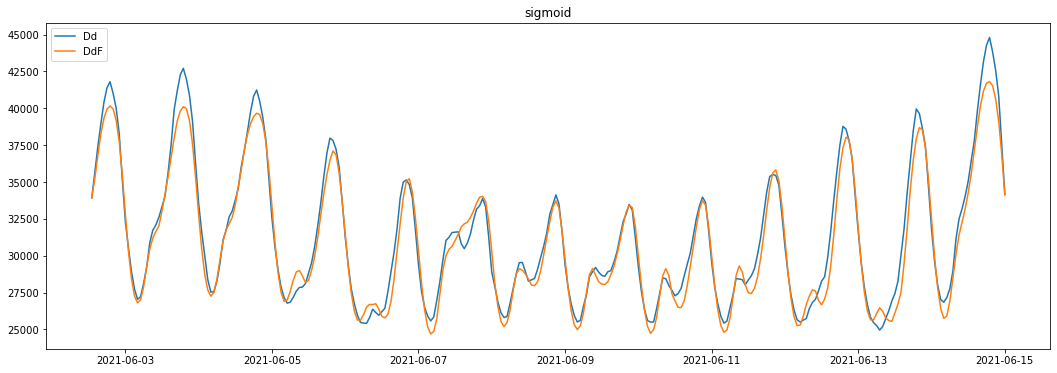

In [45]:
RNN_pred_data = pd.merge(pd.DataFrame(ts_test),RNN_pred,on=['Time'])
RNN_pred_data.columns = ['Dd','DdF']
plt.figure(figsize=(18,6))
# sns.lineplot(data=RNN_pred_data,palette="hot" )
plt.plot(RNN_pred_data)
plt.legend(RNN_pred_data)
plt.title("sigmoid")
plt.show()

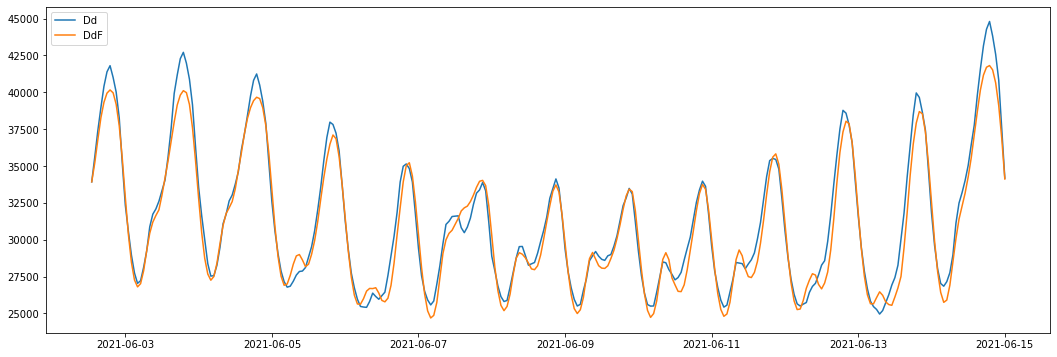

In [46]:
RNN_pred_data = pd.merge(pd.DataFrame(ts_test),RNN_pred,on=['Time'])
RNN_pred_data.columns = ['Dd','DdF']
plt.figure(figsize=(18,6))
# sns.lineplot(data=RNN_pred_data,palette="hot" )
plt.plot(RNN_pred_data)
plt.legend(RNN_pred_data)
plt.show()

In [47]:
RNN_pred_data

,Dd,DdF
Time,,
2021-06-02 13:00:00,33924,33925.820312
2021-06-02 14:00:00,35618,35217.332031
2021-06-02 15:00:00,37399,36787.496094
2021-06-02 16:00:00,38955,38267.941406
2021-06-02 17:00:00,40402,39318.117188
...,...,...
2021-06-14 20:00:00,43820,41520.210938
2021-06-14 21:00:00,42568,40637.367188
2021-06-14 22:00:00,40833,39102.699219


In [48]:
#calculate the error

from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    #print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)*100}',end='\n\n')
    return 

In [49]:
timeseries_evaluation_metrics_func(ts_test,RNN_pred)

MSE is : 897878.4532432302
MAE is : 733.9572135416666
RMSE is : 947.5644850052319
MAPE is : 15.9863350658353
R2 is : 95.92095082101191

